In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Exercise 1: VIX Analysis

1. Estimate an AR(1) time series model of the VIX using data from 1990-2015.

In [45]:
# Load excel VIX Data into pandas dataframe
vix_data = pd.read_csv('vixdata.csv', index_col='dt', parse_dates=True)

# Remove empty vix data
vix_data.dropna(inplace=True)

# Stationarity Check
adf_test = adfuller(vix_data['vix'])
print("ADF Test Results:")
print("p-value: ", adf_test[1])
if adf_test[1] > 0.05 or any(adf_test[0] > value for value in list(adf_test[4].values())):
  print("Data does not fulfill stationarity")
  exit(-1)
else:
  print("P-value is less than 0.05 so we can reject null hypothesis and data is stationary\n")

# Create indicies for in and out of sample dates
in_sample_start_date = '1990-01-02'
in_sample_end_date = '2015-12-31'
out_sample_start_date = '2016-01-04'
out_sample_end_date = '2024-02-16'
in_sample_data = vix_data[in_sample_start_date:in_sample_end_date]
out_sample_data = vix_data[out_sample_start_date:out_sample_end_date]

# Fit the AR model (with lag of 1)
model_params = AutoReg(in_sample_data['vix'].reset_index(drop=True), lags=1)
model_fit = model_params.fit()
print(model_fit.summary())

# Extract the model parameters
alpha = model_fit.params['const']
beta = model_fit.params['vix.L1']

ADF Test Results:
p-value:  1.2622382750974092e-09
P-value is less than 0.05 so we can reject null hypothesis and data is stationary

                            AutoReg Model Results                             
Dep. Variable:                    vix   No. Observations:                 6550
Model:                     AutoReg(1)   Log Likelihood              -12068.479
Method:               Conditional MLE   S.D. of innovations              1.528
Date:                Mon, 19 Aug 2024   AIC                          24142.957
Time:                        03:33:52   BIC                          24163.319
Sample:                             1   HQIC                         24149.997
                                 6550                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3723      0.051      7.319      0.000       0.273       0.4

2a) For each day in the data, use your model to calculate a 21-trading-day-ahead forecast of the VIX.  

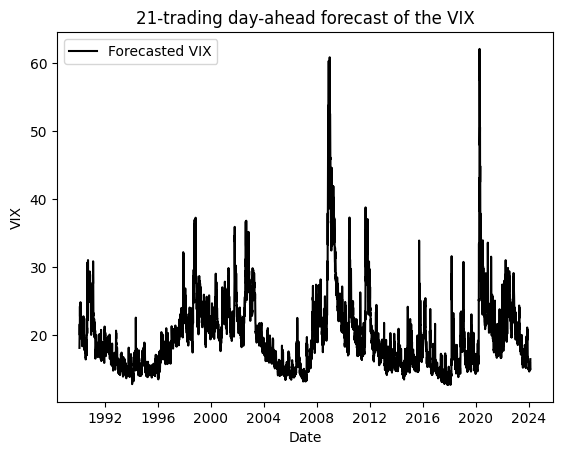

In [47]:
# Forecasting In Sample Data (using alpha and beta values)
forecast_21_day_in_sample = []

for i in range(len(in_sample_data) - 22):
  value = vix_data['vix'].iloc[i]
  for _ in range(21):
    value = alpha + beta * value
  forecast_21_day_in_sample.append(value)

forecast_21_day_in_sample = pd.Series(forecast_21_day_in_sample, index=in_sample_data.index[22:])

# Forecasting Out-of-Sample Data
forecast_21_day_out_sample = []

for i in range(len(in_sample_data), len(vix_data) - 22):
  value = vix_data['vix'].iloc[i]
  for _ in range(21):
    value = alpha + beta * value
  forecast_21_day_out_sample.append(value)

forecast_21_day_out_sample = pd.Series(forecast_21_day_out_sample, index=out_sample_data.index[22:])

concatenated_forecast = pd.concat([forecast_21_day_in_sample, forecast_21_day_out_sample])
plt.plot(concatenated_forecast.index, concatenated_forecast, label='Forecasted VIX', color='black')
plt.title('21-trading day-ahead forecast of the VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()

2b) What is the R-squared of the realized VIX on your forecast value in sample (over 1990-2015)? What about out-of-sample (2016-most recent data)?

In [48]:
in_sample_r2 = r2_score(in_sample_data.iloc[22:], forecast_21_day_in_sample)
print(f'In-Sample R-Squared: {in_sample_r2:.3f}')
out_sample_r2 = r2_score(out_sample_data.iloc[22:], forecast_21_day_out_sample)
print(f'Out-of-Sample R-Squared: {out_sample_r2:.3f}')

In-Sample R-Squared: 0.640
Out-of-Sample R-Squared: 0.345


3) Write a paragraph summarizing your observations and how you might improve the model.

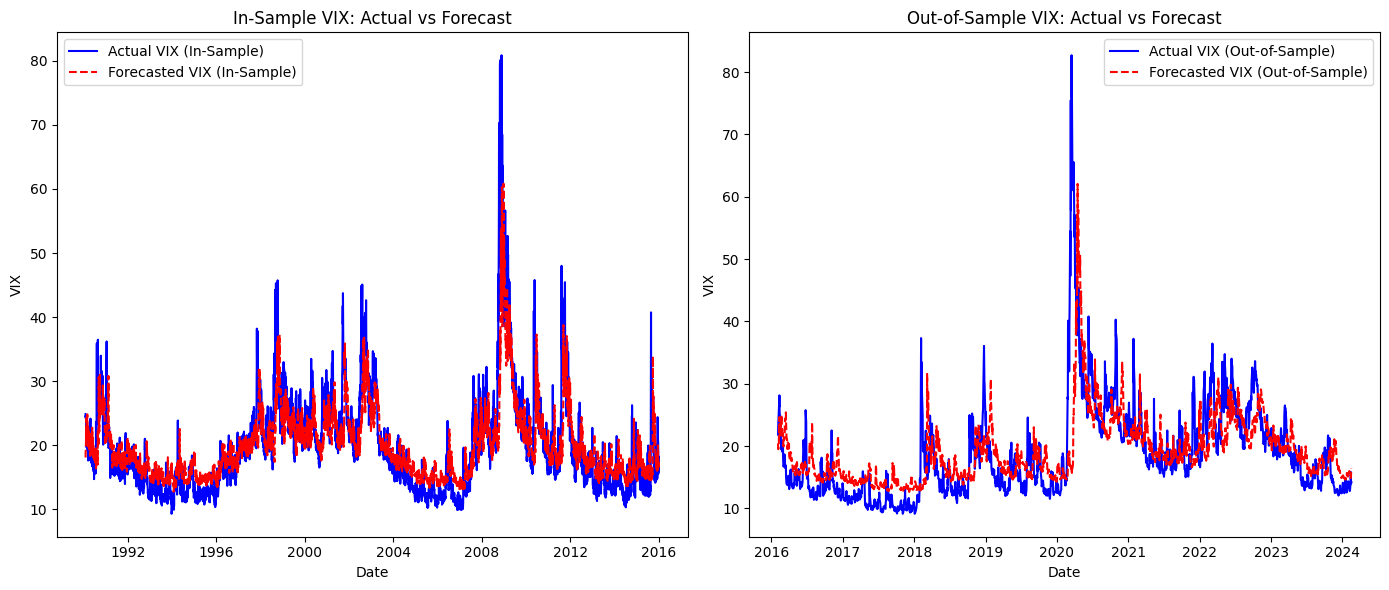

In [50]:
# Plot forecasted compared to each other for observations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the in-sample data (actual and forecasted)
axes[0].plot(in_sample_data.index[22:], in_sample_data.iloc[22:], label='Actual VIX (In-Sample)', color='blue')
axes[0].plot(forecast_21_day_in_sample.index, forecast_21_day_in_sample, label='Forecasted VIX (In-Sample)', color='red', linestyle='--')
axes[0].set_title('In-Sample VIX: Actual vs Forecast')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('VIX')
axes[0].legend()

# Plot the out-of-sample data (actual and forecasted)
axes[1].plot(out_sample_data.index[22:], out_sample_data.iloc[22:], label='Actual VIX (Out-of-Sample)', color='blue')
axes[1].plot(forecast_21_day_out_sample.index, forecast_21_day_out_sample, label='Forecasted VIX (Out-of-Sample)', color='red', linestyle='--')
axes[1].set_title('Out-of-Sample VIX: Actual vs Forecast')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('VIX')
axes[1].legend()

plt.tight_layout()
plt.show()

Summary of Findings: The AR(1) model, estimated using VIX data from 1990-2015, demonstrated a reasonably strong relationship between the 21 day trading forecast and actual vix data, as evidenced by an in-sample R-squared of 0.640. However, the out-of-sample R-squared of 0.345 revealed limitations in predicting new data, especially during periods of market stress. The model heavily relies on the previous day's value, making it difficult to handle the VIX's rapid volatility fluctuations.

Improvements to Model: To enhance accuracy, particularly in the out-of-sample data, employing a higher-order AR model could capture more complex historical patterns effectively. Evaluating and adjusting the lag length to find the optimal number of previous observations that should be included in the model can help as too few lags may overlook important information, while too many lags may introduce noise and overfitting. Additionally, utilizing ARIMA and GARCH models may provide better handling of the complex volatility dynamics. Furthermore, incorporating exogenous variables such as macroeconomic factors and market indices could significantly enhance the model's predictive power.

# Exercise 2: Portfolio Analysis

1a) Calculate a series of returns (1+Return(t) = AdjClose(t) / AdjClose(t-1)).

In [51]:
symbols = ['MSFT', 'PG', 'GSPC']
start_date = '2010-01-01'

# Read in data from csv to pandas dataframes
msft_data = pd.read_csv("MSFT.csv", index_col='Date')
pg_data = pd.read_csv("PG.csv", index_col='Date')
gspc_data = pd.read_csv("GSPC.csv", index_col='Date')

# Calculate Daily Returns
msft_returns = msft_data['Adj Close'].pct_change()
pg_returns = pg_data['Adj Close'].pct_change()
gspc_returns = gspc_data['Adj Close'].pct_change()

# Remove NaN values (eg. first row)
msft_returns = msft_returns.dropna()
pg_returns = pg_returns.dropna()
gspc_returns = gspc_returns.dropna()

1b) What are the mean and standard deviation of returns for each symbol?

In [53]:
# Combine the dataframes for calculations
combined_returns = pd.DataFrame({
    'MSFT': msft_returns,
    'PG': pg_returns,
    'GSPC': gspc_returns
})

# Calculate Mean of Returns
mean_returns = combined_returns.mean()

# Standard Deviation
standard_deviation_returns = combined_returns.std()

# Create dataframe for output of data
summary_table = pd.DataFrame({
  "Mean Return" : mean_returns,
  "Standard Deviation" : standard_deviation_returns
})

# Print standard deviation and mean data
print(summary_table)

      Mean Return  Standard Deviation
MSFT     0.000917            0.016192
PG       0.000451            0.010803
GSPC     0.000492            0.010922


1c) What are the estimated full-sample CAPM betas (and their standard errors) of MSFT and PG?

In [54]:
# Add constant to market (GSPC)
market_returns_with_const = sm.add_constant(gspc_returns)

# Individual Stock regressions
msft_model = sm.OLS(msft_returns, market_returns_with_const).fit()
pg_model = sm.OLS(pg_returns, market_returns_with_const).fit()

# Extract CAPM BETAS and Standard Errors
msft_beta = msft_model.params['Adj Close']
msft_se = msft_model.bse['Adj Close']
print(f"Microsoft CAPM Values:\n Beta: {msft_beta:.4f}\n Standard Error: {msft_se:.4f}")

pg_beta = pg_model.params['Adj Close']
pg_se = pg_model.bse['Adj Close']
print(f"PG CAPM Values:\n Beta: {pg_beta:.4f}\n Standard Error: {pg_se:.4f}")

Microsoft CAPM Values:
 Beta: 1.1222
 Standard Error: 0.0160
PG CAPM Values:
 Beta: 0.5427
 Standard Error: 0.0136


2a) Calculate the returns to a portfolio of MSFT and PG that rebalances to 50%/50% weights at the start of January.

In [55]:
# Portfolio starts at value of 1 and rebalances to 50% of total every year
weights = pd.Series([0.5, 0.5], index=['MSFT', 'PG'])

# Convert to datetime format
combined_returns.index = pd.to_datetime(combined_returns.index)

# Create dataframes for weights and portfolio value over time
weights_df = pd.DataFrame(index=combined_returns.index, columns =['MSFT', 'PG'])
portfolio_value_df = pd.DataFrame(index=combined_returns.index, columns=['Portfolio Value'])

# Calculate returns year by year and rebalance at end of year
for year in combined_returns.index.year.unique():
  yearly_returns = combined_returns[combined_returns.index.year == year]

  for date in yearly_returns.index:
    weights = (weights * (1 + yearly_returns.loc[date]))
    portfolio_value = weights.sum()

    # Store updated weights and portfolio value in dataframes
    weights_df.loc[date] = weights
    portfolio_value_df.loc[date] = portfolio_value

  # Rebalance weights at end of year
  rebalanced_value = weights.sum() / 2
  weights['MSFT'] = rebalanced_value
  weights['PG'] = rebalanced_value

# Final Portfolio Value
final_value = portfolio_value_df.iloc[-1]['Portfolio Value']
print(f'Final Portfolio Value: {final_value * 100:.2f}% of Principal Investment')

# Calculate Daily Portfolio Returns
portfolio_returns = portfolio_value_df['Portfolio Value'].pct_change().dropna()

Final Portfolio Value: 947.81% of Principal Investment


2b) What are the mean and standard deviation of returns of this portfolio?

In [42]:
# Mean Return of Returns of Rebalanced Portfolio
mean_return = portfolio_returns.mean()
print(f'Mean Return of Rebalanced Portfolio: {mean_return:.6f}')

# Standard Deviation of Returns of Rebalanced Portfolio
std_return = portfolio_returns.std()
print(f'Standard Deviation of Rebalanced Portfolio Return: {std_return:.4f}')

Mean Return of Rebalanced Portfolio: 0.000678
Standard Deviation of Rebalanced Portfolio Return: 0.0115


2c) What is the estimated CAPM beta and its standard error?

In [56]:
market_returns_with_const.index = pd.to_datetime(market_returns_with_const.index)
rebalanced_portfolio_model = sm.OLS(portfolio_returns, market_returns_with_const.loc[portfolio_returns.index]).fit()
portfolio_beta = rebalanced_portfolio_model.params['Adj Close']
portfolio_se = rebalanced_portfolio_model.bse['Adj Close']
print(f"Rebalanced Portfolio CAPM Values:\n Beta: {portfolio_beta:.4f}\n Standard Error: {portfolio_se:.4f}")

Rebalanced Portfolio CAPM Values:
 Beta: 0.8394
 Standard Error: 0.0106


3. Write a paragraph summarizing your observations.  How does your results in (2) compare to (1)?

MSFT exhibits a higher mean day-over-day return of 0.0917% and greater day-over-day volatility of 1.6192% over the 14-year period compared to PG, which has a mean day-over-day return of 0.0451% and day-over-day volatility of 1.0803%. This trend is also evident in their full-sample CAPM betas, with MSFT having a beta of 1.1222 and PG's beta at 0.5427. These figures indicate that while MSFT may be considered riskier due to its higher beta, it also offers a higher potential return compared to PG, and vice versa.


A portfolio rebalancing strategy with a 50%/50% allocation annually, at the start of every January, resulted in a mean day-over-day return of 0.0678% and a day-over-day volatility of 1.15%. When comparing these results to the stand-alone measurements MSFT and PG, we can observe that the portfolio's mean return is lower than that of MSFT but higher than PG. In terms of volatility, the portfolio's volatility is lower than MSFT but higher than PG. This more balanced market exposure is also reflected in the portfolio's CAPM beta of 0.8394. It is important to note that the low standard errors achieved in our analysis, across both stock and portfolio betas, signifies that our sample data is indeed representative of the entire data population, and in turn our “true value”.

Over the 14-year period, the rebalanced portfolio achieved an overall return of 947.81% of the principal investment, demonstrating that diversification provides a more stable and attractive risk-adjusted return compared to individual stocks.